In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network
import numpy as np

/home/asude/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
dynapse = device.DynapseDevice(sender_port=12321, receiver_port=12322)
model = dynapse.model

[0]:  Bus 3 Device 32 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 70 Dynapse1DevKit serial_number 00000032
[2]:  Bus 1 Device 65 Dynapse1DevKit serial_number 00000000
[3]:  Bus 1 Device 67 Dynapse1DevKit serial_number 00000011
[4]:  Bus 1 Device 69 Dynapse1DevKit serial_number 00000007
[5]:  Bus 1 Device 71 Dynapse1DevKit serial_number 00000020
[6]:  Bus 1 Device 64 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12321
Receiver port: tcp://0.0.0.0:12322
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [54]:
num_neurons = 15
neuron_ids1 = np.arange(1,num_neurons+1)
neuron_ids2 = np.arange(num_neurons+1, 2*num_neurons+1)
num_all_neurons = 2*num_neurons
neuron_ids = np.arange(1, num_all_neurons+1)

# init a network generator
net = network.DynapseNetworkGenerator()
neurons1 = net.get_neurons(0, 0, neuron_ids1)
neurons2 = net.get_neurons(0, 0, neuron_ids2)

net.add_connections_all_to_all(neurons1, neurons1, network.SYNAPSE_AMPA, weight=1, probability=0.8)
net.add_connections_all_to_all(neurons2, neurons2, network.SYNAPSE_AMPA, weight=1, probability=0.8)
net.add_connections_all_to_all(neurons1, neurons2, network.SYNAPSE_GABA_B, weight=1, probability=1)
net.add_connections_all_to_all(neurons2, neurons1, network.SYNAPSE_GABA_B, weight=1, probability=1)

dynapse.monitor_neuron_network(neurons1+neurons2)
model.apply_configuration(net.get_config())

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


Population frequency f is 27.583333 Hz.
Pop1 frequency f is 22.066667 Hz.
Pop2 frequency f is 33.100000 Hz.
Population frequency f is 0.433333 Hz.
Population frequency f is 6.888889 Hz.
Pop1 frequency f is 0.000000 Hz.
Pop2 frequency f is 13.777778 Hz.


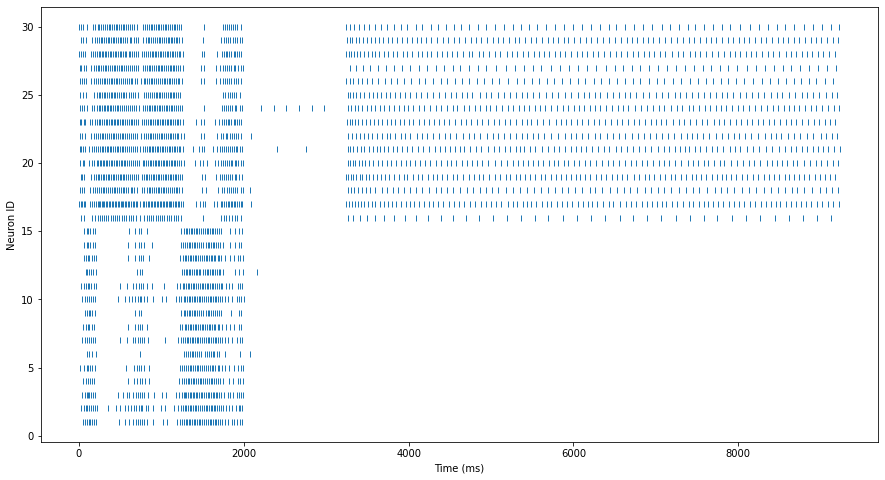

In [91]:
# # set params
parameters.set_all_default_params(model)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (3,50), 0, 0)
parameters.set_param(model, parameters.AMPA_WEIGHT, (6, 44), 0, 0)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (5,46), 0, 0)
#parameters.set_param(model, parameters.AMPA_TIME_CONSTANT, (2,80), 0, 0)

parameters.set_param(model, parameters.ADAPTATION_CASCODE, (0,0), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_WEIGHT, (0,0), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_TIME_CONSTANT, (0,0), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_GAIN, (0,0), 0, 0)

duration1 = 2
duration_stop = 1
duration2 = 6
spikes = []

dynapse.start_graph()
dynapse.run_simulation(0.1) # bug with clearing the buffer at the moment - need to run the simulation for a little 

these_spikes = dynapse.run_simulation(duration1)
spikes_array = np.vstack(([spike.timestamp for spike in these_spikes],[spike.id for spike in these_spikes])).T
pop_freq = len(spikes_array)/duration1/num_all_neurons
print('Population frequency f is %f Hz.' %pop_freq)
pop1 = np.where(spikes_array[:,1] < num_neurons+1)
pop1_freq = len(pop1[0])/num_neurons/duration1
pop2 = np.where(spikes_array[:,1] > num_neurons)
pop2_freq = len(pop2[0])/num_neurons/duration1
print('Pop1 frequency f is %f Hz.' %pop1_freq)
print('Pop2 frequency f is %f Hz.' %pop2_freq)
spikes += these_spikes

parameters.set_param(model, parameters.NEURON_DC_INPUT, (0,0), 0, 0)
parameters.set_param(model, parameters.AMPA_WEIGHT, (0, 0), 0, 0)
these_spikes = dynapse.run_simulation(duration_stop)
spikes_array = np.vstack(([spike.timestamp for spike in these_spikes],[spike.id for spike in these_spikes])).T
pop_freq = len(spikes_array)/duration_stop/num_all_neurons
print('Population frequency f is %f Hz.' %pop_freq)
spikes += these_spikes

parameters.set_param(model, parameters.NEURON_DC_INPUT, (3,50), 0, 0)
parameters.set_param(model, parameters.AMPA_WEIGHT, (6, 44), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_CASCODE, (5,150), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_WEIGHT, (6,130), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_TIME_CONSTANT, (3,100), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_GAIN, (4,125), 0, 0)
these_spikes = dynapse.run_simulation(duration2)
spikes_array = np.vstack(([spike.timestamp for spike in these_spikes],[spike.id for spike in these_spikes])).T
pop_freq = len(spikes_array)/duration2/num_all_neurons
print('Population frequency f is %f Hz.' %pop_freq)
pop1 = np.where(spikes_array[:,1] < num_neurons+1)
pop1_freq = len(pop1[0])/num_neurons/duration2
pop2 = np.where(spikes_array[:,1] > num_neurons)
pop2_freq = len(pop2[0])/num_neurons/duration2
print('Pop1 frequency f is %f Hz.' %pop1_freq)
print('Pop2 frequency f is %f Hz.' %pop2_freq)
spikes += these_spikes

dynapse.stop_graph()

spikes = np.vstack(([spike.timestamp for spike in spikes],[spike.id for spike in spikes])).T
spikes[:,0] -= spikes[0,0]

plt.figure(figsize=[15,8])
plt.plot(spikes[:,0]/1000, spikes[:,1], '|')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.show()


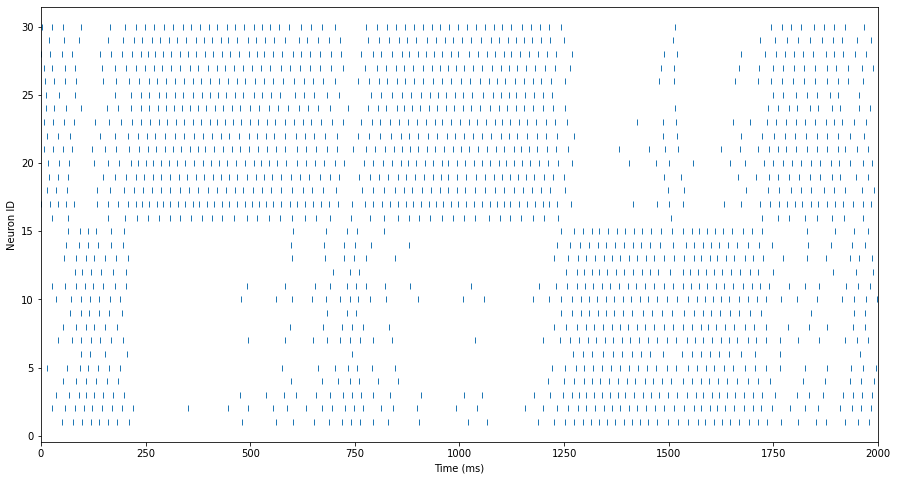

In [92]:
plt.figure(figsize=[15,8])
plt.plot(spikes[:,0]/1000, spikes[:,1], '|')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.xlim([0,2000])
plt.show()

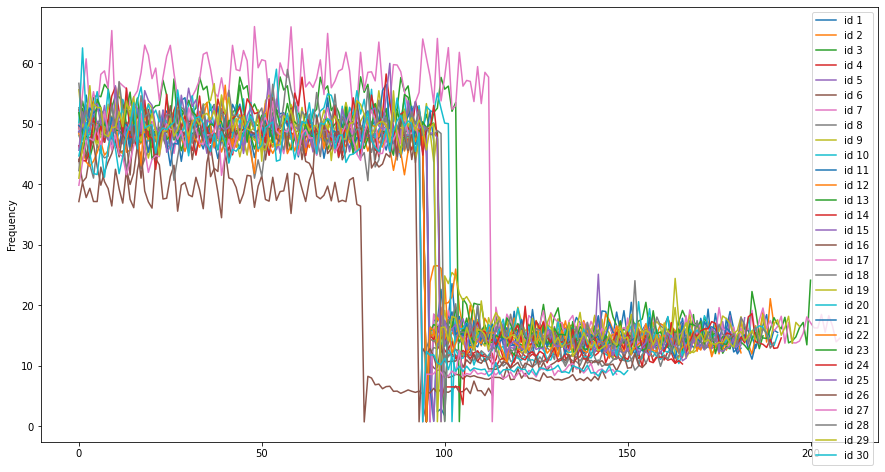

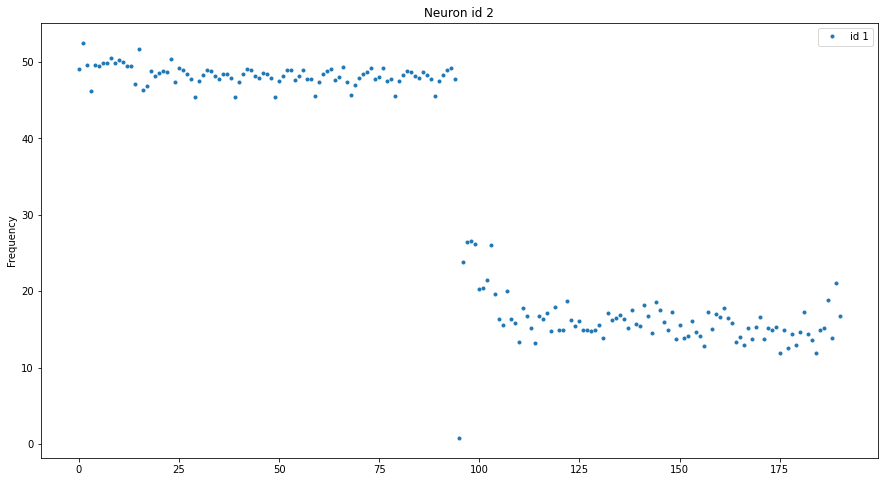

In [73]:
plt.figure(figsize=[15,8])
rates = []

neuron_ids = np.arange(1, num_all_neurons+1)
for neuron_id in neuron_ids:
    where_id = np.where(spikes[:,1] == neuron_id)
    neuron_rates = 1e6/np.diff(spikes[where_id,0]) # in sec 
    neuron_rates = neuron_rates[0]
    rates.append(neuron_rates)
    plt.plot(neuron_rates, label = 'id %s' %neuron_id)
plt.legend()
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=[15,8])
id = 1
plt.plot(rates[id], '.', label = 'id %s' %id)
plt.legend()
plt.ylabel('Frequency')
real_id = id + 1
plt.title('Neuron id %s' %real_id)
plt.show()

In [ ]:
f0 = all_freqs[0]
l0 = f0.tolist()
f1 = all_freqs[1]
l1 = f1.tolist()
print(l0)
print(l0+l1)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(25,10))
axs[0].plot(spikes[:,0]/1000, spikes[:,1], '|')
axs[1].plot(vary, all_pop_freqs)
axs[0].set_ylabel('Neuron ID')
axs[0].set_xlabel('Time (ms)')
axs[1].set_ylabel('frequency')
axs[1].set_xlabel('DC fine values for coarse 3')
plt.show()

In [ ]:
sorted_spikes_array = np.sort(spikes_array, axis=0)

plt.figure(figsize=[15,8])
for neuron_id in neuron_ids:
    where_id = np.where(spikes_array[:,1] == neuron_id)
    neuron_id_freq = 1e6/np.diff(spikes_array[where_id,0]) # in sec 
    neuron_id_freq = neuron_id_freq[0]
    plt.plot(neuron_id_freq, label = 'id %s' %neuron_id)
plt.legend()




# print(spikes_array[:,0])

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(25,10))
axs[0].plot(spikes_array[:,0]/1000, spikes_array[:,1], '|')
axs[1].plot(pop_spikes)
axs[0].set_xlim([0,100])
axs[0].set_ylabel('Neuron ID')
axs[1].set_ylabel('frequency')
plt.show()

In [ ]:
print(spikes[:,1])